In [85]:
import pandas as pd
import re
import string
import numpy as np

In [86]:
products = pd.DataFrame.from_csv('amazon_baby_subset.csv')
important_words = pd.read_json('important_words.json')[0].tolist()

In [87]:
products = products.fillna({'review': ''})

In [88]:
regex = re.compile('[%s]' % re.escape(string.punctuation))
def remove_punctuation(text):
    return regex.sub('', text)
products['clean_review'] = products['review'].apply(remove_punctuation)

In [90]:
for word in important_words:
    products[word] = products['clean_review'].apply(lambda s: s.split().count(word))

In [91]:
train_idx = pd.read_json('module-10-assignment-train-idx.json')[0]
validation_idx = pd.read_json('module-10-assignment-validation-idx.json')[0]

In [92]:
products = products.reset_index()

In [93]:
train_data = products.ix[train_idx]
valid_data = products.ix[validation_idx]

In [94]:
# convert dataframe to multi-dimensional array
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    features_frame = dataframe[features]
    feature_matrix = features_frame.as_matrix()
    label_parray = dataframe[label]
    label_array = label_parray.as_matrix()
    return (feature_matrix.astype(float), label_array.astype(float))

In [95]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')

In [96]:
feature_matrix_valid, sentiment_valid = get_numpy_data(valid_data, important_words, 'sentiment')

In [97]:
def predict_probability(feature_matrix, coefficients):
    score = np.dot(feature_matrix, coefficients)
    return 1 / (np.exp(-score) + 1)

In [98]:
def feature_derivative(errors, feature):
    derivative = np.dot(feature, errors)
    return derivative

In [99]:
def compute_avg_log_likelihood(feature_matrix, sentiment, coefficients):
    indicators = sentiment == 1
    scores = np.dot(feature_matrix, coefficients)
    logexp = np.log(1 + np.exp(-scores))
    
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]
    
    lp = np.sum((indicators - 1)*scores - logexp) / len(feature_matrix)
    
    return lp

In [100]:
j = 1                        # Feature number
i = 10                       # Data point number
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+1,:], coefficients)
indicator = (sentiment_train[i:i+1]==+1)

errors = indicator - predictions
gradient_single_data_point = feature_derivative(errors, feature_matrix_train[i:i+1,j])
print("Gradient single data point: %s" % gradient_single_data_point)
print("           --> Should print 0.0")

Gradient single data point: 0.0
           --> Should print 0.0


In [101]:
j = 1                        # Feature number
i = 10                       # Data point start
B = 10                       # Mini-batch size
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+B,:], coefficients)
indicator = (sentiment_train[i:i+B]==+1)

errors = indicator - predictions
gradient_mini_batch = feature_derivative(errors, feature_matrix_train[i:i+B,j])
print("Gradient mini-batch data points: %s" % gradient_mini_batch)
print("                --> Should print 1.0")

Gradient mini-batch data points: 1.0
                --> Should print 1.0


In [151]:
def logistic_regression_SG(feature_matrix, sentiment, initial_coefficients, step_size, batch_size, max_iter, suppress_log=False):
    log_likelihood_all = []
    coefficients = initial_coefficients
    
    np.random.seed(seed=1)
    premutation = np.random.permutation(len(feature_matrix))
    feature_matrix = feature_matrix[premutation,:]
    sentiment = sentiment[premutation]
    
    i = 0
    for d in range(max_iter):
        predictions = predict_probability(feature_matrix[i:i+batch_size, :], coefficients)
        indicators = (sentiment[i:i+batch_size] == 1)
        
        errors = indicators - predictions
        for j in range(len(coefficients)):
            gradient_j = feature_derivative(errors, feature_matrix[i:i+batch_size, j])
            gradient_j = gradient_j * step_size / float(batch_size)
            coefficients[j] = coefficients[j] + gradient_j
        avg_log_likehood = compute_avg_log_likelihood(feature_matrix[i:i+batch_size,:], sentiment[i:i+batch_size], coefficients)
        
        log_likelihood_all.append(avg_log_likehood)
        
        if not suppress_log and d%100 == 0:
            print('Iteration {}, average log likelihood {}'.format(d, avg_log_likehood))
        i = i + batch_size
        
        if i + batch_size > len(feature_matrix):
            premutation = np.random.permutation(len(feature_matrix))
            feature_matrix = feature_matrix[premutation,:]
            sentiment = sentiment[premutation]
            i = 0
    return coefficients, log_likelihood_all

In [152]:
initial_coefficients = np.zeros(194)
step_size = 5e-1
batch_size = 1
max_iter = 10

In [153]:
coefficients_1, log_likehood_all_1 = logistic_regression_SG(feature_matrix_train, sentiment_train, initial_coefficients, step_size, batch_size, max_iter)

Iteration 0, average log likelihood -0.25192908134537295


In [126]:
initial_coefficients = np.zeros(194)
step_size = 5e-1
batch_size = len(feature_matrix_train)
max_iter = 200

In [127]:
coefficients_2, log_likehood_all_2 = logistic_regression_SG(feature_matrix_train, sentiment_train, initial_coefficients, step_size, batch_size, max_iter)

Iteration 0, average log likelihood -0.6830811890078895
Iteration 100, average log likelihood -0.4952019380712874


In [129]:
# Quiz Question Suppose that we run stochastic gradient ascent with a 
# batch size of 100. How many gradient updates are performed at the end 
# of two passes over a dataset consisting of 50000 data points?

# len(coefficients) * 2 * 50000 / 100

In [131]:
import matplotlib.pyplot as plt
%matplotlib inline

def make_plot(log_likelihood_all, len_data, batch_size, smoothing_window=1, label=''):
    plt.rcParams.update({'figure.figsize': (9,5)})
    log_likelihood_all_ma = np.convolve(np.array(log_likelihood_all), \
                                        np.ones((smoothing_window,))/smoothing_window, mode='valid')

    plt.plot(np.array(range(smoothing_window-1, len(log_likelihood_all)))*float(batch_size)/len_data,
             log_likelihood_all_ma, linewidth=4.0, label=label)
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.xlabel('# of passes over data')
    plt.ylabel('Average log likelihood per data point')
    plt.legend(loc='lower right', prop={'size':14})

In [137]:
step_size=1e-1
batch_size=100
initial_coefficients = np.zeros(194)

In [140]:
sga, log_likehood_sga = logistic_regression_SG(feature_matrix_train, sentiment_train, initial_coefficients, step_size, batch_size, 200)

Iteration 0, average log likelihood -0.4848855699244056
Iteration 100, average log likelihood -0.560227196270545


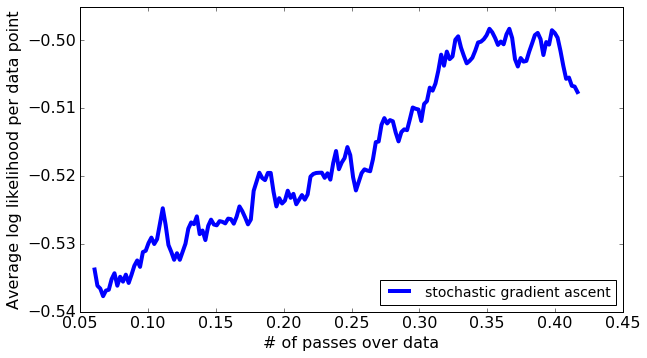

In [160]:
# stochastic gradient ascent 
make_plot(log_likehood_sga, len(feature_matrix_train), batch_size, 30, 'stochastic gradient ascent')

D:\Users\zeyang\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


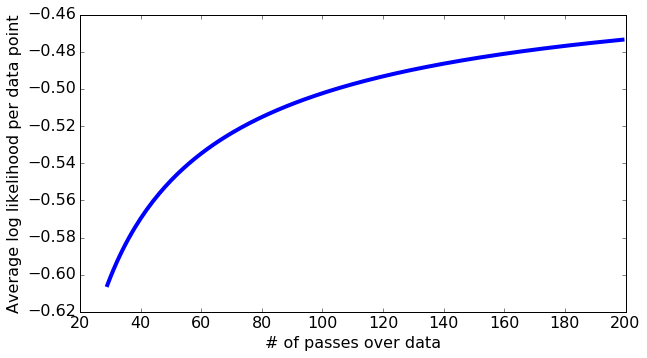

In [142]:
# batch gradient ascent
make_plot(log_likehood_all_2, len(feature_matrix_train), len(feature_matrix_train), 30, 'batch gradient ascent')

In [143]:
step_sizes = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]

In [157]:
initial_coefficients=np.zeros(194)
batch_size=100
max_iter = int(10 * len(feature_matrix_train) / batch_size)

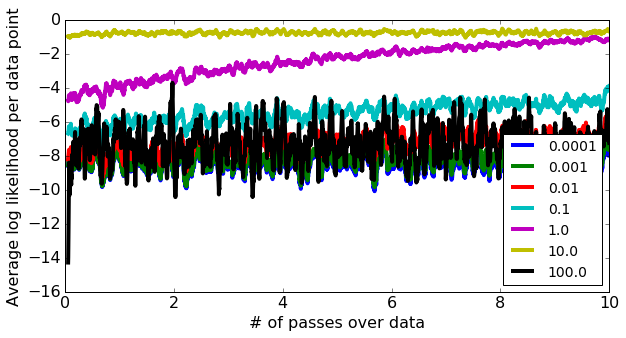

In [161]:
performances = {}
for s in step_sizes:
    coefficients, log_likehood = logistic_regression_SG(feature_matrix_train, sentiment_train, initial_coefficients, s, batch_size, max_iter, True)
    make_plot(log_likehood, len(feature_matrix_train), batch_size, 30, s)
    performances[s] = log_likehood[-1]

In [162]:
performances

{0.0001: -4.0027577912255534,
 0.001: -3.8275533429121888,
 0.01: -3.0194646348044034,
 0.1: -2.2617964038279625,
 1.0: -0.69682859901845262,
 10.0: -0.37885174386689058,
 100.0: -3.8618326624948969}

In [164]:
len(train_data)

47780